# Louis George    

## Feature Engineering

In [1]:
import numpy as np
import pandas as pd

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [9]:
plt.style.use('ggplot')

#### Warning: Lots of the functions in this notebook take a LONG time to run!

### Reading in the data

In [2]:
df = pd.read_csv('../../data/df_clean.csv')

In [3]:
df.head()

,titles,IMDb_score,RT_score,Gross_world,Budget,scripts,genres
0,10 Things I Hate About You,0.73,0.68,53478166,30000000,TEN THINGS I HA...,Comedy|Romance
1,12,0.77,0.76,7537453,4000000,\n \n\n\n\n\nCUT FROM BLACK\n\nTITLE: FIN\n...,Comedy
2,12 and Holding,0.75,0.73,119195,400000,\n \n \n ...,Drama
3,12 Monkeys,0.80,0.89,168839459,29000001,TWELVE MONKEYS\n \n An orig...,Drama|SciFi|Thriller
4,12 Years a Slave,0.81,0.95,187733202,20000000,12 YEARS A SLAVE\...,Drama


In [4]:
X = df.iloc[:, -2:]
y = df.iloc[:, :5]

### Dummying the genres:

In [6]:
X = pd.concat((X, X['genres'].str.get_dummies()), axis=1).drop('genres', axis=1)

In [7]:
X.shape

(922, 23)

### Writing the preprocessing, and tokenizing function

There are a lot of numbers in the scripts from the formatting, so I want to remove those.

In [296]:
def my_preprocessor(string):
    no_d = ''.join([i for i in string if not i.isdigit()])
    return no_d.lower()

I will remove stopwords, punctuation, and some other unwanted things in the tokenizing function, as well as lemmatize.

In [297]:
def my_tokenizer(string):
    # Initializing the spacy class
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(string)
    # List to append accepted tokens to
    tokens = []
    # Condition for a good token
    for token in doc:

        if (token.is_stop == False) & \
           (token.is_punct == False) & \
           (token.is_space == False) & \
           ('\n' not in str(token)):
            
            tokens.append(token.lemma_)

    return tokens

### Creating some additional features    
Warning: Takes a LONG time to run!

In [155]:
# Initializing columns
X['Num_NOUN'], X['Num_PRON'], X['Num_PROPN'], X['Num_ADJ'], X['Num_VERB'], X['Num_ADV'] = 0, 0, 0, 0, 0, 0

# Iterating over all scripts
for i in range(X.shape[0]):
    
    # Initializing the spacy class
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(X['scripts'][i])

    # Condition for a good token
    for token in doc:
        if (token.is_stop == False) & \
           (token.is_punct == False) & \
           (token.is_space == False) & \
           ('\n' not in str(token)):
            pos = token.pos_
            # Condition for each POS
            if pos == 'NOUN':
                X['Num_NOUN'][i] += 1
            elif pos == 'PRON':
                X['Num_PRON'][i] += 1
            elif pos == 'PROPN':
                X['Num_PROPN'][i] += 1
            elif pos == 'ADJ':
                X['Num_ADJ'][i] += 1
            elif pos == 'VERB':
                X['Num_VERB'][i] += 1
            elif pos == 'ADV':
                X['Num_ADV'][i] += 1
    print(f'Just finished: {i}', end='\r')

C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\louis\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value i

In [156]:
X.tail()

,scripts,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,...,Sport,Thriller,War,Western,Num_NOUN,Num_PRON,Num_PROPN,Num_ADJ,Num_VERB,Num_ADV
917,You've Got Mail\n\n by Nora Ephron & Deli...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,3612,5,3558,816,2900,341
918,\n \n\n ...,0,0,0,0,1,0,1,0,0,...,0,0,0,0,4647,5,4016,936,3072,387
919,\n ZERO DARK ...,0,0,0,0,0,0,1,0,0,...,0,1,0,0,3554,8,3829,817,2453,263
920,ZEROPHI...,0,0,0,0,1,0,0,0,0,...,0,0,0,0,2102,11,2242,606,1744,240
921,ZOOTOPIA\n\n\n\n\n...,0,1,1,0,1,0,0,0,0,...,0,0,0,0,3258,36,3545,786,2385,299


This script takes a long time to run, so I will export a copy of the dataframe from this point, and then load it and then reload it for the remainder of the steps. I'm doing this because I will be tuning the vectorizer, and don't want to have to rerun this function.

In [165]:
X.to_csv('../../data/X_plus.csv', columns=X.columns, index=False)

### Engineering the targets

Defining a new target as the percent profit of the film.    
This will be defined as:   
Percent Profit = Cumulative Worldwide Gross / Budget * 100   
Answer rounded to the nearest hundreth

In [5]:
y['Per_Profit'] = round((y['Gross_world'] / y['Budget'] * 100), 2)

In [6]:
y.head()

,titles,IMDb_score,RT_score,Gross_world,Budget,Per_Profit
0,10 Things I Hate About You,0.73,0.68,53478166,30000000,178.26
1,12,0.77,0.76,7537453,4000000,188.44
2,12 and Holding,0.75,0.73,119195,400000,29.80
3,12 Monkeys,0.80,0.89,168839459,29000001,582.21
4,12 Years a Slave,0.81,0.95,187733202,20000000,938.67


In [7]:
y.describe().T

,count,mean,std,min,25%,50%,75%,max
IMDb_score,922.0,7.003796e-01,8.920184e-02,0.24,6.500000e-01,7.100000e-01,7.600000e-01,9.300000e-01
RT_score,922.0,6.772343e-01,2.524599e-01,0.01,5.025000e-01,7.400000e-01,8.900000e-01,1.000000e+00
Gross_world,922.0,1.475749e+08,2.256299e+08,2554.00,2.140068e+07,6.574693e+07,1.865084e+08,2.790439e+09
Budget,922.0,3.997570e+07,4.174143e+07,7000.00,1.100000e+07,2.700000e+07,5.500000e+07,2.500000e+08
Per_Profit,922.0,6.045202e+02,1.576577e+03,0.05,1.116825e+02,2.694150e+02,5.225975e+02,2.915600e+04


Maybe combine the imdb and rt scores into a score ratio?

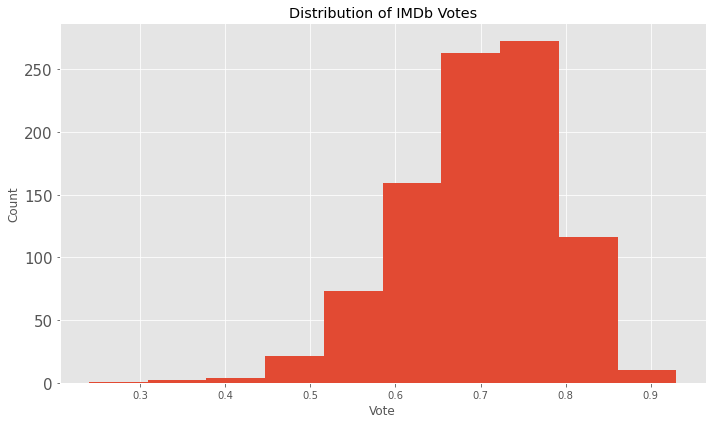

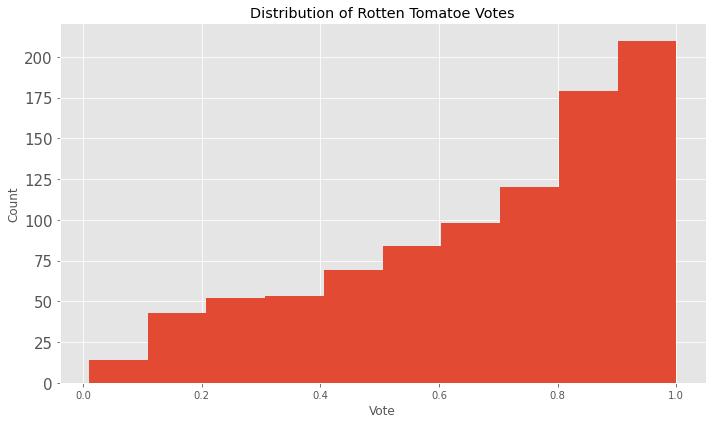

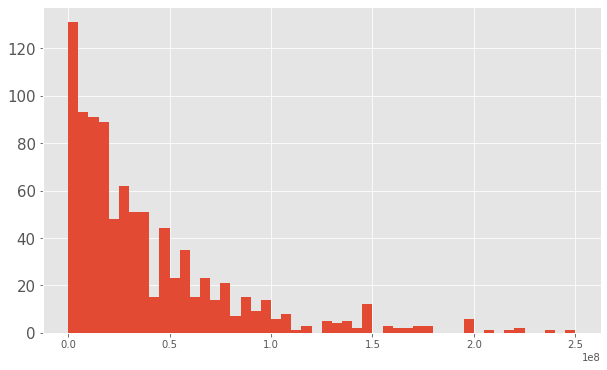

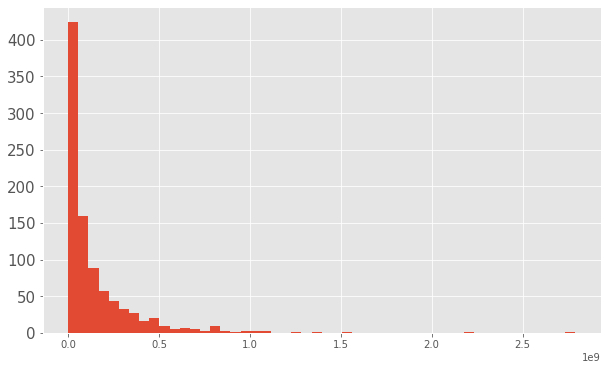

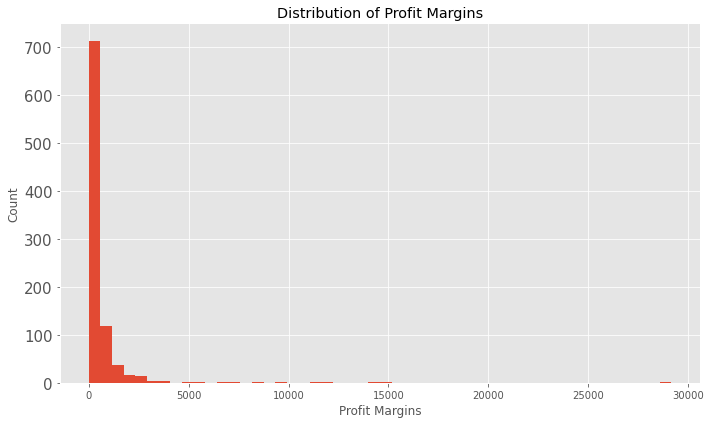

In [12]:
plt.figure(figsize=(10, 6))
plt.hist(y.IMDb_score)
plt.title("Distribution of IMDb Votes")
plt.xlabel("Vote")
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"../plots/imdb_hist.png");

plt.figure(figsize=(10, 6))
plt.hist(y.RT_score)
plt.title("Distribution of Rotten Tomatoe Votes")
plt.xlabel("Vote")
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"../plots/rt_hist.png");

plt.figure(figsize=(10, 6))
plt.hist(y.Budget, bins=50)
plt.show();

plt.figure(figsize=(10, 6))
plt.hist(y.Gross_world, bins=50)
plt.show();

plt.figure(figsize=(10, 6))
plt.hist(y.Per_Profit, bins=50)
plt.title("Distribution of Profit Margins")
plt.xlabel("Profit Margins")
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"../plots/profit_hist.png");

**IMDb Score:**    
Because the distribution is a nice and normal looking, I will categorize this variable at 0.70, which is right around both the mean and median.    

**RT Score:**    
It's interesting that this distribution is differenct from IMDbs, and gives me hope that there may be some insights to be gained here. Because this does not look like a normal distribution I'm going to split this at a more arbitrary value. Although RT classifies anything better than 60% as "fresh", we can see that there is a definite spike around 0.80, and the median score is 0.74. For this reason I will try a cutoff of 0.80, and reevaluate if necessary.    

**Budget:**    
Not sure if I'll classify this or not yet, might do regression for this and gross rev

**Cumulative Gross Worldwide:**
Same as above.

**Percent Profit:**
Accoding to an article published in Gizmodo, they give a general rule of thumb stating that a movie must make twice it's budget in order to break even. I will therefore select 200% as the cutoff for the Percent Profit target variable. This also is close to the median, which is about 260%.      

https://io9.gizmodo.com/how-much-money-does-a-movie-need-to-make-to-be-profitab-5747305

In [28]:
# Exporting the raw data to reference later
y.to_csv('../../data/y_wt.csv', columns=y.columns, index=False)

In [12]:
def imdb_converter(score):
    if score < 0.70:
        new_score = 0
    else:
        new_score = 1
    return new_score

In [13]:
def rt_converter(score):
    if score < 0.80:
        new_score = 0
    else:
        new_score = 1
    return new_score

In [14]:
def profit_converter(score):
    if score < 200:
        new_score = 0
    else:
        new_score = 1
    return new_score

In [15]:
y['IMDb_score'] = y['IMDb_score'].map(imdb_converter)
y['RT_score'] = y['RT_score'].map(rt_converter)
y['Per_Profit'] = y['Per_Profit'].map(profit_converter)

#### Baseline case for comparison

In [16]:
print(f"IMDb baseline: {round(y['IMDb_score'].mean(), 3)}")
print(f"RT baseline: {round(y['RT_score'].mean(), 3)}")
print(f"Percent Profit baseline: {round(y['Per_Profit'].mean(), 3)}")

IMDb baseline: 0.569
RT baseline: 0.433
Percent Profit baseline: 0.612


In [17]:
y.head()

,titles,IMDb_score,RT_score,Gross_world,Budget,Per_Profit
0,10 Things I Hate About You,1,0,53478166,30000000,0
1,12,1,0,7537453,4000000,0
2,12 and Holding,1,0,119195,400000,0
3,12 Monkeys,1,1,168839459,29000001,1
4,12 Years a Slave,1,1,187733202,20000000,1


In [23]:
# Exporting the targets
y.drop('titles', axis=1).to_csv('../../data/y.csv', columns=y.drop('titles', axis=1).columns, index=False)

### Splitting the data

In [18]:
X_n = pd.read_csv('../../data/X_plus.csv')

In [19]:
X_n.shape

(922, 29)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_n, y, random_state=4)

In [21]:
X_train.shape

(691, 29)

### Vectorizing the scripts using TFIDF

WARNING This step takes a long time to run!

In [399]:
tfidf = TfidfVectorizer(min_df=0.1, 
                        max_df=0.9, 
                        preprocessor=my_preprocessor, 
                        tokenizer=my_tokenizer, 
                        ngram_range=(1,3)).fit(X_train['scripts'])

In [400]:
X_train_tfidf_transformed = tfidf.transform(X_train['scripts'])
X_test_tfidf_transformed = tfidf.transform(X_test['scripts'])

In [401]:
X_train_tfidf.shape

(858, 998)

min_df = 1 gives 110878 features.    
min_df = 2 gives 47064 features. (run in colab)    
min_df = 0.5 & max_df = 0.9 gives 970 features.

In [408]:
X_train_tfidf_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=X_train_tfidf_transformed.toarray())
X_test_tfidf_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=X_test_tfidf_transformed.toarray())

X_train_tfidf_df.head()

,$,-PRON-,-year,-year old,`,` -PRON-,a-,a.,a.m.,aback,...,young woman,youth,yup,zero,zip,zipper,zombie,zone,zoo,zoom
0,0.000000,0.007865,0.0,0.0,0.131437,0.018577,0.0,0.0,0.00000,0.000000,...,0.015613,0.0,0.0,0.000000,0.004010,0.0,0.0,0.004831,0.0,0.000000
1,0.000000,0.010707,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.006188,...,0.000000,0.0,0.0,0.005848,0.021837,0.0,0.0,0.000000,0.0,0.022053
2,0.042285,0.017041,0.0,0.0,0.000000,0.000000,0.0,0.0,0.01922,0.000000,...,0.000000,0.0,0.0,0.003103,0.000000,0.0,0.0,0.006978,0.0,0.017549
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,0.000000,...,0.000000,0.0,0.0,0.000000,0.008857,0.0,0.0,0.000000,0.0,0.008944


In [409]:
X_train_tfidf_df.sum().sort_values(ascending=False).head(20)

cont'd               53.655885
continue continue    20.765109
to                   20.495675
phone                19.922083
guy                  19.751696
v.o                  18.648882
yeah                 18.584725
mr                   18.081873
jack                 18.035416
frank                16.596192
sam                  16.570697
okay                 16.444741
charlie              16.031591
gun                  15.463812
go to                15.430299
john                 14.869862
o.s                  14.283981
paul                 13.700698
fuck                 13.431680
max                  13.390542
dtype: float64

In [410]:
X_train_tfidf_f = pd.concat([X_train.drop('scripts', axis=1).reset_index(drop=True), X_train_tfidf_df], axis=1)
X_test_tfidf_f = pd.concat([X_test.drop('scripts', axis=1).reset_index(drop=True), X_test_tfidf_df], axis=1)

### Vectorizing using count vectorizer    
Primarily for use with LDA - probably won't be used as its own metric.     
Warning: This step also takes a long time to run.

In [402]:
bagofwords = CountVectorizer(min_df=0.1, 
                             max_df=0.9, 
                             preprocessor=my_preprocessor, 
                             tokenizer=my_tokenizer, 
                             ngram_range=(1,3)).fit(X_train['scripts'])

In [403]:
X_train_countv_transformed = bagofwords.transform(X_train['scripts'])
X_test_countv_transformed = bagofwords.transform(X_test['scripts'])

In [404]:
X_train_countv_transformed.shape

(858, 998)

In [405]:
X_train_countv_df = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_train_countv_transformed.toarray())
X_test_countv_df = pd.DataFrame(columns=bagofwords.get_feature_names(), data=X_test_countv_transformed.toarray())

X_train_countv_df.head()

,$,-PRON-,-year,-year old,`,` -PRON-,a-,a.,a.m.,aback,...,young woman,youth,yup,zero,zip,zipper,zombie,zone,zoo,zoom
0,0,3,0,0,28,3,0,0,0,0,...,4,0,0,0,1,0,0,1,0,0
1,0,3,0,0,0,0,0,0,0,1,...,0,0,0,1,4,0,0,0,0,4
2,14,9,0,0,0,0,0,0,5,0,...,0,0,0,1,0,0,0,2,0,6
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,2


In [406]:
X_train_countv_df.sum().sort_values(ascending=False).head(20)

cont'd     27383
to         14021
mr         13402
phone      13383
guy        13375
jack       13318
yeah       13113
okay       11167
go to      10097
v.o         9873
gun         9691
camera      9637
john        8976
office      8819
o.s         8385
sam         8176
charlie     7962
frank       7916
george      7359
angle       7297
dtype: int64

In [407]:
X_train_countv_f = pd.concat([X_train.drop('scripts', axis=1).reset_index(drop=True), X_train_countv_df], axis=1)
X_test_countv_f = pd.concat([X_test.drop('scripts', axis=1).reset_index(drop=True), X_test_countv_df], axis=1)

### Exporting the targets and features

TFIDF

In [411]:
X_train_tfidf_f.to_csv('../../data/X_train_tfidf.csv', columns=X_train_tfidf_f.columns, index=False)
X_test_tfidf_f.to_csv('../../data/X_test_tfidf.csv', columns=X_test_tfidf_f.columns, index=False)

COUNT V

In [412]:
X_train_countv_f.to_csv('../../data/X_train_countv.csv', columns=X_train_countv_f.columns, index=False)
X_test_countv_f.to_csv('../../data/X_test_countv.csv', columns=X_test_countv_f.columns, index=False)

Isolating the targets

In [22]:
y_imdb_train = y_train.iloc[:, 1]
y_rt_train = y_train.iloc[:, 2]
y_profit_train = y_train.iloc[:, -1]

y_imdb_test = y_test.iloc[:, 1]
y_rt_test = y_test.iloc[:, 2]
y_profit_test = y_test.iloc[:, -1]

Exporting the targets

In [93]:
y_imdb_train.to_csv('../../data/y_imdb_train.csv', header=True, index=False)
y_rt_train.to_csv('../../data/y_rt_train.csv', header=True, index=False)
y_profit_train.to_csv('../../data/y_profit_train.csv', header=True, index=False)

y_imdb_test.to_csv('../../data/y_imdb_test.csv', header=True, index=False)
y_rt_test.to_csv('../../data/y_rt_test.csv', header=True, index=False)
y_profit_test.to_csv('../../data/y_profit_test.csv', header=True, index=False)